In [1]:
'''
Python notebook script for telescope IR modeling.
This python notebook is modified from Jamie Bock's spreadsheet and Denis Barkats' python script.
Major revision: 
a)read model data from file.
b)calculation is base on frequency other than wave number.
c)fix bugs. avoid overflow error when calculate Planck spectrum.
d)upgrade modeling:
    1. Use diffuse approximation to calculate the transmission between layers, because a pencil beam is 
       not a good assumption in this calculation. We should multiply the optical depth by a factor of 1.66.
    2. Use the avarage temperature, (Th + Tc)/2 to calculate radiation from a layer, other than use Th.
e)extend temperature range to 1 K - 402 K.

By Lingzhen Zeng, Dec 17 2019. 
last updated, Mar 04 2020. 
email: lingzhen@cfa.harvard.edu
Thank Scott Paine for usefull discusson. 
'''

"\nPython notebook script for telescope IR modeling.\nThis python notebook is modified from Jamie Bock's spreadsheet and Denis Barkats' python script.\nMajor revision: \na)read model data from file.\nb)calculation is base on frequency other than wave number.\nc)fix bugs. avoid overflow error when calculate Planck spectrum.\nd)upgrade modeling:\n    1. Use diffuse approximation to calculate the transmission between layers, because a pencil beam is \n       not a good assumption in this calculation. We should multiply the optical depth by a factor of 1.66.\n    2. Use the avarage temperature, (Th + Tc)/2 to calculate radiation from a layer, other than use Th.\ne)extend temperature range to 1 K - 402 K.\n\nBy Lingzhen Zeng, Dec 17 2019. \nlast updated, Mar 04 2020. \nemail: lingzhen@cfa.harvard.edu\nThank Scott Paine for usefull discusson. \n"

In [2]:
## import modules
#physical constants from https://docs.scipy.org/doc/scipy/reference/constants.html
import scipy.constants as const
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, minimize

In [3]:
#Conductivity and transmission coefficients of materials are defined in this cell.
#For transmission: 
#A and B are conventional values for using with the units of cm, and icm in IR wavelength:
#alpa(wn) = A wn**B +C
#wn = 1/lambda=nu/c
#Trx(wn) = exp(-alpha*t), where wn is in icm, and t is in cm. 

def alumina_scale():
    """
    guess at thermal conductivity
    in W/ m K
    based on Inoue et al 2014. https://arxiv.org/pdf/1311.5388v4.pdf
    page 2, Alumina at 77-90K, thermal conductivity: 144+-35 W/ m K
    """
    T = np.arange(1,402)  # temp in K
    K = np.zeros(np.size(T)) +  144
    A = 7.4e-4
    B = 1.8
    return T, K, A, B
def alumina_compl():
    """
    in W/ m K
    based on: Jamie's updated spreadsheet
    Source: ??
    """
    T = np.arange(1,402)  # temp in K
    lT = np.log10(T)      # log(temp)
    c_Alumina = [-2.19334, 3.37049, -0.86346,0.62581,-0.24706]
    expo = 0
    for i, c in enumerate(c_Alumina):
        expo = expo + c * lT**i
    K =  10**(expo) 
    A = 7.4e-4
    B = 1.8
    return T, K, A, B
def fquartz():  #fused quartz
    """
    guess at thermal conductivity
    in W/ m K
    Source:? from https://arxiv.org/pdf/1311.5388v4.pdf, it should be 18.7. 
    """
    T = np.arange(1,402)  # temp in K
    K = np.zeros(np.size(T)) +  6
    A = 4.18e-4
    B = 2.3
    return T, K, A, B
def zfoam():
    """
    from http://www.zotefoams.com/pages/de/datasheets/hd30.htm
    in W/ m K
    """
    T = np.arange(1,402)  # temp in K
    K = np.zeros(np.size(T)) +  0.047
    A = 1.0e-3
    B = 1.0
    return T, K, A, B
def teflon():
    """
    computes the conductivity_n from Teflon  thermal conductivity W/ m K , 
    from Jamie's spreadsheet
    from http://cryogenics.nist.gov/MPropsMAY/material%20properties.htm
    """
    T = np.arange(1,402)  # temp in K
    lT = np.log10(T)   # log(temp)
    c_teflon = [2.738,-30.677,89.43,-136.99, 124.69, -69.556, 23.32, -4.3135, 0.33829]
    c = c_teflon

    expo = 0
    for i in range(np.size(c)):
        expo = expo + c[i] * lT**i
    K =  10**(expo)
    A = 5.52e-4
    B = 1.35
    return T, K, A, B
def nylon():
    """
    computes the Nylon thermal conductivity K(T) in W/ m K
    from Jamie's spreadsheet
    from http://cryogenics.nist.gov/MPropsMAY/material%20properties.htm
    """
    T = np.arange(1,402)  # temp in K
    lT = np.log10(T)      # log(temp)
    c_nylon = [-2.6135, 2.3239, -4.7586, 7.1602, -4.9155, 1.6324, -0.2507, 0.0131]
    c = c_nylon
    expo = 0
    for i in range(np.size(c)):
        expo = expo + c[i] * lT**i
    K =  10**(expo) 
    A = 7.3e-5
    B = 3.55
    return T, K, A, B
def hdpe():
    """
    computes the HDPE thermal conductivity K(T),
    from Jamie's spreadsheet
    """
    T = np.arange(1,430)  # temp in K
    K = np.zeros(429)
    for i in range(np.size(T)):
        if T[i] < 22:
            K[i]=0.0136*T[i]**1.75
        elif T[i] < 39:
            K[i]=0.395*T[i]**0.677
        elif T[i] < 99:
            K[i]=0.615*T[i]**.577
        else:
            K[i]=28.6*T[i]**(-.277)
    K = 0.1*K
    A = 9.49e-3
    B = 1.0
    return T, K, A, B

In [4]:
#subroutines section

def B_nu(nu,T):    
    """
    input nu (frequency) and T,  physical temperature (K)
    returns spectral radiance in units of W m^-2 Hz^-1 sr^-1 of the black body spectrum
    """
    expo = const.h * nu / (const.k *T)
    for i in range(len(expo)): 
        if expo[i] > 700.0: #eleminate large values to prevent overflow error 
            expo[i] = 700.0
    B = (2 * const.h * nu**3)/ (const.c**2) / (np.exp(expo) -1 ) 
    return B
def P_load(nu,Spec,layer):
    '''
    Calculates the total power load impinging on a layer caused by Spec.
    '''
    dSpec = Spec[1:]*np.diff(nu)
    Ptot = np.sum(dSpec) * layer['sr'] * const.pi * (layer['d']/2)**2
    return Ptot
def Trx_layer(nu,layer):
    '''
    Calculate the transmission for a given layer.
    inputs: nu is frequency array in Hz
    returns the transmission  between 0 and 1.
    Since A and B are typically for icm and cm in IR wavelength, 
    '''
    T,K,A,B = globals()[layer['material']]()
    wn = nu/3.0e10  #convert frequency (Hz) to wave number (icm)
    alpha = A * wn**B
    Trx = np.exp(- layer['t']*100*1.66 * alpha)  #thickness converted from m to cm
    # the factor of 1.66 is from diffuse approximation
    return Trx
def P_cond(layer):
    """
    given a curve of T and K thermal conductivities.K in W / m K
    given a  layer thickness thick in cm.
    This calculates the  conductive power heat flow between two temperatures assuming the heat 
    flows outwards in a cylindrical fashion
    Tc (Tcold) and Th (Thot) in Kelvin, assuming a uniform power deposition (4PI)
    """    
    T,K,A,B = globals()[layer['material']]()
    Thot = layer['Th']
    Tcold = layer['Tc']
    thickness = layer['t']
    if Thot < Tcold:
        Pcdut = np.exp(20 * (Tcold - Thot))
        #Pcdut = 0.0
    else:
        T2 = np.linspace(min(T),max(T),len(T)*1000)
        K2 = np.interp(T2,T,K)
        # cumulative thermal conductance in W/m for uniform power deposition
        H = np.diff(T2)*np.cumsum(K2)[1:] *4*const.pi 
        qc = np.mean(np.nonzero(abs(T2-Tcold) <1.0e-3))
        qh = np.mean(np.nonzero(abs(T2-Thot) <1.0e-3))        
        #print qc,qh
        if(np.isnan(qc)):
            qc = len(H)-1
        if(np.isnan(qh)):
            qh = len(H)-1
        Pcdut = thickness * (H[int(qh)] - H[int(qc)])
    return Pcdut
def P_res(Th, layer, Pabs):
    '''
    Return the residual power for a layer, given Th and Spectrum absorbed
    '''
    Teff = (Th+layer['Tc'])/2 #effective temperature is average on Th and Tc
    #Teff = Th
    layer['Th']=Th
    Pcdut = P_cond(layer)
    Spectmp = B_nu(nu,Teff)
    Ptmp = P_load(nu,Spectmp,layer)
    return abs(Pabs - 2*Ptmp - Pcdut)

Power coming from ambient 1.13e+02 W
---------------------
window
Ptrans from prev layer : 1.13e+02 W
Power absorbed in layer: 1.41e+02 W
Initial Th: 290.000 K, Optimized Th: 250.000 K
Power rad by current layer : 7.77e+01 W
Power trans to next layer: 7.77e+01 W
=== Power balance check ===
layer thickness: 3.175 cm, Thot= 250.000 K, Tcold= 250.000 K, Delta_T_layer= 0.000 K
+ Pabs= 1.41e+02 W, - 2*Prad= 1.55e+02 W, - Pcond= 0.00e+00 W, Pbalance= -1.47e+01 W
---------------------
zfoam
Ptrans from prev layer : 7.77e+01 W
Power absorbed in layer: 6.46e+01 W
Initial Th: 160.000 K, Optimized Th: 276.343 K
Power rad by current layer : 3.09e+01 W
Power trans to next layer: 3.34e+01 W
=== Power balance check ===
layer thickness: 3.175 cm, Thot= 276.343 K, Tcold= 130.000 K, Delta_T_layer= 146.343 K
+ Pabs= 6.46e+01 W, - 2*Prad= 6.18e+01 W, - Pcond= 2.74e+00 W, Pbalance= 1.88e-10 W
---------------------
alumina_filter_50K
Ptrans from prev layer : 3.34e+01 W
Power absorbed in layer: 2.83e+01 W
In

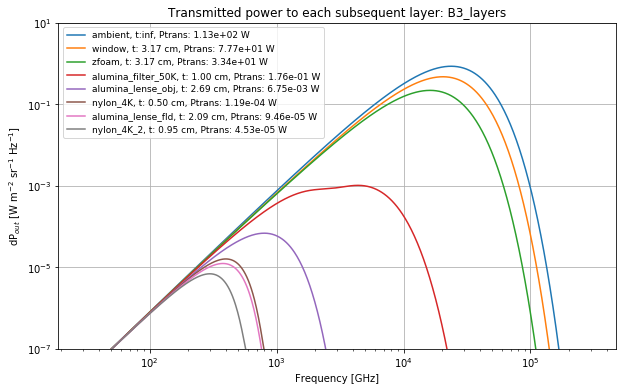

In [5]:
#main function to calculate the thermal radiative model for a given input from file

#construct frequency array in Hz
fstart = 30.0 #start frequency in GHz
fstop = 300000.0 #stop freqency in GHz
nstep = 1000 #number of steps
ind = np.log10(fstop/fstart)/nstep
nu = []
nu.append(fstart*1.0e9)
for i in range(nstep):
    nu.append(nu[-1]*10**(ind))
nu = np.array(nu)

#read layers from file
filename = 'B3_layers'
#filename = 'SAT_hdpe_worst_layers'
infile = open(filename + '.txt', "r")
layers = []
line=infile.readline()
while line:
    line=line.strip()
    if line[0] != '#':
        wordlist = line.split()
        layers.append({'name':wordlist[0],'material':wordlist[1],
                       't':float(wordlist[2]),'d':float(wordlist[3]), 'sr': float(wordlist[4]), 
                       'Th':float(wordlist[5]),'Tc':float(wordlist[6])})
        #print(wordlist)                  
    line=infile.readline()                     
infile.close()
     
#define variables for layers
legd = [] # legend for the plots
Spec = []  #plank spectrum at each layer
Pabs = [] #absorbed power at each layer
Prad = [] #radiated power at each layer
Ptrans = [] #transmitted power at each layer

'''
At the ith layer, Trx[i] is the transmition under diffusion approximation, 
T_eff is the effective temperature, then we have: 
P_abs[i] = (1-Trx[i])*P_trans[i-1]
P_rad[i] = B_nu(nv,T_eff)
P_trans[i] = Trx[i]*P_trans[i-1]+(1-Trx[i])*P_rad[i]
'''

#caculate the total load from ambient
Spec.append(B_nu(nu,layers[0]['Th']))
Pambient = P_load(nu,Spec[0],layers[0])
Pabs.append(Pambient)
Prad.append(Pambient)
Ptrans.append(Pambient)
print('Power coming from ambient {:6.2e} W'.format(Pambient))

plt.figure(figsize=(10,6))
plt.clf()
plt.loglog(nu[1:]/1.0e9, Spec[0][1:]*np.diff(nu))
plt.ylim([1e-7, 10])
plt.grid()
plt.xlabel('Frequency [GHz]')
plt.ylabel('dP$_{out}$ [W m$^{-2}$ sr$^{-1}$ Hz$^{-1}$]')
legd.append('ambient, t:inf, Ptrans: %6.2e W'%Ptrans[0])

for counter,layer in enumerate(layers[1:]):
    counter = counter + 1
    print('---------------------')
    print(layer['name'])
    Trx = Trx_layer(nu, layer)  #caculate transmission
    print('Ptrans from prev layer : {:6.2e} W'.format(Ptrans[counter-1]))
    Specabsorb = (1-Trx) * Spec[-1] #spectrum absorbed in the current layer
    Pabsorb = P_load(nu,Specabsorb,layer) #total power load on the current layer
    Pabs.append(Pabsorb)
    print('Power absorbed in layer: {:6.2e} W'.format(Pabsorb))
    #caculate T_hot at equilibrium
    Th = layer['Th']
    res = minimize(P_res, Th, args=(layer,Pabsorb), method='Nelder-Mead', tol=1.0e-9)
    print('Initial Th: {:5.3f} K, Optimized Th: {:5.3f} K'.format(Th, res.x[0]))
    layer['Th'] = res.x[0]
    Pcond =  P_cond(layer)
    Specradlayer = B_nu(nu,0.5*(layer['Th']+layer['Tc'])) #effective temperature is average on Th and Tc
    #Specradlayer = B_nu(nu,layer['Th']) 
    Pradlayer = P_load(nu,Specradlayer,layer)
    Prad.append(Pradlayer)
    print('Power rad by current layer : {:6.2e} W'.format(Pradlayer))
    Specoutlayer= Spec[-1] * Trx + (1-Trx)* Specradlayer
    Poutlayer = P_load(nu,Specoutlayer,layer)
    Ptrans.append(Poutlayer)
    print('Power trans to next layer: {:6.2e} W'.format(Poutlayer))
    Spec.append(Specoutlayer)
    plt.loglog(nu[1:]/1.0e9, Spec[-1][1:]*np.diff(nu))
    legd.append('%s, t: %.2f cm, Ptrans: %6.2e W'%(layer['name'],layer['t']*100, Ptrans[-1]))
    plt.legend(legd,prop={'size': 9},loc=2)
    
    print('=== Power balance check ===')
    print('layer thickness: {:5.3f} cm, Thot= {:5.3f} K, Tcold= {:5.3f} K, Delta_T_layer= {:5.3f} K'.format(layer['t']*100, layer['Th'], layer['Tc'], layer['Th']-layer['Tc']) )
    print('+ Pabs= {:6.2e} W, - 2*Prad= {:6.2e} W, - Pcond= {:6.2e} W, Pbalance= {:6.2e} W'.format(Pabs[counter], 2*Prad[counter], Pcond, Pabs[counter] - 2*Prad[counter] - Pcond))
    
plt.title('Transmitted power to each subsequent layer: ' + filename)
plt.savefig(filename + '_transmitted_power.pdf')